### Convolutional Neural Networks

In [1]:
# In this notebook, we will train CNN to classify CIFAR-10 database

#### Test for CUDA

In [2]:
import torch
import numpy as np

# check if cuda is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available, Training on CPU...')
else:
    print('CUDA is available, Training on GPU...')

CUDA is available, Training on GPU...


#### Load Data

In [3]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)

# obtain training indices that will be use for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)



# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



Files already downloaded and verified
Files already downloaded and verified


#### Visualize a Batch of Training Data

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0))) # convert from Tensor image

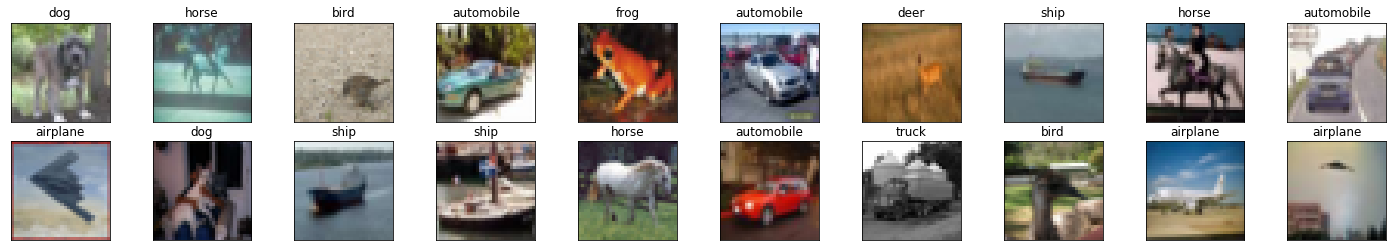

In [5]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

#### Define the Network Architecture

In [6]:
import torch.nn as nn
import torch.nn.functional as F

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
model = Net()
model

if train_on_gpu:
    model.cuda()

#### Define loss and optimizer

In [8]:
from torch import optim

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

#### Train the Network

In [10]:
import numpy as np

n_epochs = 30

valid_loss_min = np.Inf

for epoch in range(1, n_epochs+1):
    train_loss = 0
    valid_loss = 0
    
    #train the model
    model.train()
    for data, target in train_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    #validate the model
    model.eval()
    for data, target in valid_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
    
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    print('Epoch: {} \tTraning Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model...'.format(
            valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Traning Loss: 1.690684 	Validation Loss: 0.365476
Validation loss decreased (inf --> 0.365476). Saving model...
Epoch: 2 	Traning Loss: 1.340417 	Validation Loss: 0.301782
Validation loss decreased (0.365476 --> 0.301782). Saving model...
Epoch: 3 	Traning Loss: 1.176079 	Validation Loss: 0.272880
Validation loss decreased (0.301782 --> 0.272880). Saving model...
Epoch: 4 	Traning Loss: 1.072479 	Validation Loss: 0.266662
Validation loss decreased (0.272880 --> 0.266662). Saving model...
Epoch: 5 	Traning Loss: 0.989130 	Validation Loss: 0.230523
Validation loss decreased (0.266662 --> 0.230523). Saving model...
Epoch: 6 	Traning Loss: 0.922807 	Validation Loss: 0.218496
Validation loss decreased (0.230523 --> 0.218496). Saving model...
Epoch: 7 	Traning Loss: 0.865578 	Validation Loss: 0.215179
Validation loss decreased (0.218496 --> 0.215179). Saving model...
Epoch: 8 	Traning Loss: 0.811760 	Validation Loss: 0.194288
Validation loss decreased (0.215179 --> 0.194288). Savin

#### Load the model with lowest validation loss

In [11]:
model.load_state_dict(torch.load('model_cifar.pt'))

#### Test the train network

In [12]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.410045

Test Accuracy of airplane: 91% (4557/5000)
Test Accuracy of automobile: 94% (4707/5000)
Test Accuracy of  bird: 78% (3903/5000)
Test Accuracy of   cat: 78% (3912/5000)
Test Accuracy of  deer: 83% (4160/5000)
Test Accuracy of   dog: 84% (4245/5000)
Test Accuracy of  frog: 88% (4409/5000)
Test Accuracy of horse: 90% (4541/5000)
Test Accuracy of  ship: 94% (4736/5000)
Test Accuracy of truck: 94% (4704/5000)

Test Accuracy (Overall): 87% (43874/50000)
